# Project 02: One ligand against several targets

This notebook shows how plipify can be used to compare the binding modes of a small molecule towards multiple protein. This can be especially interesting for protein families with selectivity issues, for example kinases.

**Workflow:**  
01. Retrieve data from KLIFS  
02. Analyze data with plipify  
03. Generate publication ready figures  

## 01. Retrieve data from KLIFS

In [1]:
import logging
logging.getLogger("plip").setLevel(logging.WARNING)
logging.getLogger("opencadd").setLevel(logging.WARNING)

from tqdm.auto import tqdm
import pandas as pd
from opencadd.databases.klifs import setup_remote

In [2]:
# Set up remote session
klifs = setup_remote()

In [3]:
# retrieve kinase structures
kinase_df = klifs.structures.all_structures()

In [4]:
# remove structures without orthosteric ligand
kinase_df = kinase_df[kinase_df["ligand.expo_id"] != "-"]

In [5]:
# sort by quality
kinase_df = kinase_df.sort_values(by=["structure.qualityscore", "structure.resolution"],ascending=[False, True])

In [6]:
# find unique kinase ligand pairs
kinase_ligand_pairs_df = kinase_df.groupby(["kinase.klifs_id", "ligand.expo_id"]).head(1)

In [7]:
# find ligands binding to many kinases
topligands = kinase_ligand_pairs_df.groupby("ligand.expo_id").size().sort_values(ascending=False)
topligands.head()

ligand.expo_id
ANP    76
ADP    51
STU    40
ATP    32
ACP    19
dtype: int64

More details for these ligands:

In [8]:
import html
ligand_details = klifs.ligands.by_ligand_expo_id(topligands.index[:10].tolist())
ligand_details["ligand.name"] = ligand_details["ligand.name"].apply(html.unescape)
ligand_details

,ligand.klifs_id,ligand.expo_id,ligand.name,ligand.smiles,ligand.inchikey
0,26,ADP,ADENOSINE-5'-DIPHOSPHATE,P(=O)(OP(=O)(O)O)(OC[C@H]1O[C@@H](N2c3ncnc(N)c...,XTWYTFMLZFPYCI-KQYNXXCUSA-N
1,28,STU,STAUROSPORINE,O=C1NCc2c3c4N(c5c3cccc5)[C@]6(O[C@@H](N7c4c(c8...,HKSZLNNOFSGOKW-FYTWVXJKSA-N
2,38,AGS,PHOSPHOTHIOPHOSPHORIC ACID-ADENYLATE ESTER,S=P(OP(=O)(OP(=O)(OC[C@H]1O[C@@H](N2c3ncnc(N)c...,NLTUCYMLOPLUHL-KQYNXXCUSA-N
3,48,STI,4-(4-METHYL-PIPERAZIN-1-YLMETHYL)-N-[4-METHYL-...,O=C(Nc1cc(Nc2nc(c3cnccc3)ccn2)c(cc1)C)c4ccc(cc...,KTUFNOKKBVMGRW-UHFFFAOYSA-N
4,63,ATP,ADENOSINE-5'-TRIPHOSPHATE,P(=O)(OP(=O)(OC[C@H]1O[C@@H](N2c3ncnc(N)c3N=C2...,ZKHQWZAMYRWXGA-KQYNXXCUSA-N
5,64,ANP,PHOSPHOAMINOPHOSPHONIC ACID-ADENYLATE ESTER,P(=O)(OP(=O)(O)NP(=O)(O)O)(OC[C@H]1O[C@@H](N2c...,PVKSNHVPLWYQGJ-KQYNXXCUSA-N
6,140,AMP,ADENOSINE MONOPHOSPHATE,P(=O)(OC[C@H]1O[C@@H](N2c3ncnc(N)c3N=C2)[C@H](...,UDMBCSSLTHHNCD-KQYNXXCUSA-N
7,160,ACP,PHOSPHOMETHYLPHOSPHONIC ACID ADENYLATE ESTER,P(=O)(OP(=O)(O)CP(=O)(O)O)(OC[C@H]1O[C@@H](N2c...,UFZTZBNSLXELAL-IOSLPCCCSA-N
8,252,DB8,"4-[(2,4-dichloro-5-methoxyphenyl)amino]-6-meth...",Clc1c(OC)cc(Nc2c(C#N)cnc3c2cc(OC)c(OCCCN4CCN(C...,UBPYILGKFZZVDX-UHFFFAOYSA-N
9,281,1N1,N-(2-CHLORO-6-METHYLPHENYL)-2-({6-[4-(2-HYDROX...,Clc1c(NC(=O)C=2SC(=NC2)Nc3nc(nc(N4CCN(CCO)CC4)...,ZBNZXTGUTAYRHI-UHFFFAOYSA-N


### Get PDB files

In [9]:
from pathlib import Path

LIGAND = "STU"  # any ligand expo id, see above for relevant options

HERE = Path(_dh[-1])
DATA = HERE / "data" / LIGAND
OUT = HERE / "output" / LIGAND
DATA.mkdir(exist_ok=True, parents=True)
OUT.mkdir(exist_ok=True, parents=True)

Retrieve all Human structures for ligand=${LIGAND}, and keep the first result for each kinase ID (we don't want to bias the interactions for the most popular kinases). We need a 2nd query to get the families and groups in case we want to cluster results later.

In [10]:
structures_for_ligand = (
    klifs.structures.by_ligand_expo_id(LIGAND)
    .query("`species.klifs` == 'Human'")
    .drop_duplicates(subset=["kinase.klifs_id"])
    # TODO: Choose by best structure.qualityscore (best = high values)
)
families_and_groups = klifs.kinases.by_kinase_klifs_id(structures_for_ligand["kinase.klifs_id"].tolist())
structures_for_ligand["kinase.family"] = families_and_groups["kinase.family"].tolist()
structures_for_ligand["kinase.group"] = families_and_groups["kinase.group"].tolist()

structures_for_ligand.head()

,structure.klifs_id,structure.pdb_id,structure.alternate_model,structure.chain,species.klifs,kinase.klifs_id,kinase.klifs_name,kinase.family,kinase.group,structure.pocket,...,structure.bp_ii_b_in,structure.bp_ii_out,structure.bp_ii_b,structure.bp_iii,structure.bp_iv,structure.bp_v,structure.grich_distance,structure.grich_angle,structure.grich_rotation,structure.filepath
0,7087,5loh,B,B,Human,22,MASTL,MAST,AGC,KPISRGAFGKVYLYAVKVV_________ALSKPFIVHLYYSYLVME...,...,False,False,False,False,False,False,17.7132,57.4790,7.84068,None
4,3164,1oky,A,A,Human,27,PDK1,PDK1,AGC,KILGEGSFSTVVLYAIKILYVTRERDVMSRLDPFFVKLYFTYFGLS...,...,False,False,False,False,False,False,17.0610,57.3762,55.58310,None
6,5357,1xjd,-,A,Human,37,PKCt,PKC,AGC,KMLGKGSFGKVFLFAIKALCTMVEKRVLSLAWPFLTHMFCTFFVME...,...,False,False,False,False,False,False,15.2886,50.6519,78.08330,None
7,1867,3a62,-,A,Human,51,p70S6K,RSK,AGC,RVLGKGGYGKVFQFAMKVL____ERNILEEVKPFIVDLIYAYLILE...,...,False,False,False,False,False,False,17.2877,54.9376,74.46290,None
12,2777,2z7r,-,A,Human,54,RSK1,RSK,AGC,KVLGQGSFGKVFLYAMKVL_______ILADVNPFVVKLHYAYLILD...,...,False,False,False,False,False,False,16.0725,54.4858,50.99290,None


In [11]:
if not list(DATA.glob("*")):  # if dir is empty, download
    for row in tqdm(structures_for_ligand.to_dict("records")):
        outdir = DATA / str(row["structure.klifs_id"])
        klifs.coordinates.to_pdb(row["structure.klifs_id"], outdir)

In [12]:
pdbs = sorted((DATA).glob("**/*.pdb"))
klifsid2pdb = {int(pdb.parent.name): pdb for pdb in pdbs}    

__TODO__: We need to convert mol2 to pdb for nglview and plipify compatibility. We could download the PDBs directly, but some residue numbers are wrong, apparently.

Compare the files in the DATA folders.

In [13]:
import nglview as nv

view = nv.NGLWidget()
for pdb in pdbs[:10]:
    structure = nv.adaptor.FileStructure(str(pdb))
    view.add_component(structure)
view.center(LIGAND)
view

NGLWidget()

Get their pocket numbering

In [14]:
pockets = {}
for row in tqdm(structures_for_ligand.to_dict("records")):
    kid = row["structure.klifs_id"]
    pocket = klifs.pockets.by_structure_klifs_id(kid)
    pocket["chain_id"] = row["structure.chain"]
    pockets[kid] = pocket

display(pocket)

,residue.klifs_id,residue.id,residue.klifs_region_id,residue.klifs_region,residue.klifs_color,chain_id
0,1,801,I.1,I,khaki,A
1,2,802,I.2,I,khaki,A
2,3,803,I.3,I,khaki,A
3,4,804,g.l.4,g.l,green,A
4,5,805,g.l.5,g.l,green,A
...,...,...,...,...,...,...
80,81,964,xDFG.81,xDFG,cornflowerblue,A
81,82,965,xDFG.82,xDFG,cornflowerblue,A
82,83,966,xDFG.83,xDFG,cornflowerblue,A
83,84,967,a.l.84,a.l,cornflowerblue,A


In [15]:
with pd.option_context('display.max_rows', 100): 
    display(pocket)

,residue.klifs_id,residue.id,residue.klifs_region_id,residue.klifs_region,residue.klifs_color,chain_id
0,1,801,I.1,I,khaki,A
1,2,802,I.2,I,khaki,A
2,3,803,I.3,I,khaki,A
3,4,804,g.l.4,g.l,green,A
4,5,805,g.l.5,g.l,green,A
5,6,806,g.l.6,g.l,green,A
6,7,807,g.l.7,g.l,green,A
7,8,808,g.l.8,g.l,green,A
8,9,809,g.l.9,g.l,green,A
9,10,810,II.10,II,khaki,A


## 02. Analyze data with plipify

In [16]:
from plipify.core import Structure
from plipify.fingerprints import InteractionFingerprint

In [17]:
structures = {kid: Structure.from_pdbfile(str(path), ligand_identifier=LIGAND) for kid, path in tqdm(klifsid2pdb.items())}

Enable this cell below to debug the interactions by analyzing their raw data as available in PLIP.

We filter out some unwanted structures?

- only those with a single binding site
- that corresponds to the ligand we requested

In [18]:
picked_structures = []
pocket_mappings = []
final_klifs_ids = []
for klifs_id in structures_for_ligand["structure.klifs_id"].tolist():
    structure = structures[klifs_id]
    pocket = pockets[klifs_id]
    # FIXME: consider a smarter check here, this might be too restrictive
    if len(structure.binding_sites) == 1 and structure.binding_sites[0].name.startswith(LIGAND):
        final_klifs_ids.append(klifs_id)
        picked_structures.append(structure)
        mapping = {}
        for _, klifs_resid, seq_resid, chain in pocket[["residue.klifs_id", "residue.id", "chain_id"]].itertuples():
            # This mapping key will be the LABEL of the fingerprint, sorting must be stable wrt to residue numbers
            mapping[f"KLI{klifs_resid:02d}"] = {
                # these keys must match signature in plipify.core.Structure.get_residue_by
                "seq_index": int(seq_resid) if seq_resid != "_" else None,
                "chain": chain,
            }
        pocket_mappings.append(mapping)

In [19]:
fp = InteractionFingerprint().calculate_fingerprint(
        picked_structures,
        residue_indices=pocket_mappings,
        labeled=True, 
        as_dataframe=True, 
        remove_non_interacting_residues=True,
        remove_empty_interaction_types=True,
        ensure_same_sequence=False
    )

if not fp.values.shape[0]:
    raise ValueError("Fingerprint is empty!")

fp.style.background_gradient(axis=None, cmap="YlGnBu")

! Warning, could not process structure <Structure with 294 residues, 0 ligands and 1 binding sites (loaded from file `/home/jaime/devel/py/volkamerlab/plipify/projects/02/data/STU/1312/HUMAN_MAPKAPK2_1nxk_chainC_complex.pdb`)> due to error `ValueError`: No residue with such sequence index: 94, C!
! Warning, could not process structure <Structure with 267 residues, 0 ligands and 1 binding sites (loaded from file `/home/jaime/devel/py/volkamerlab/plipify/projects/02/data/STU/2444/HUMAN_PIM1_1yhs_chainA_complex.pdb`)> due to error `ValueError`: No residue with such sequence index: 161, A!


,hydrophobic,hbond-don,hbond-acc,waterbridge,pistacking
KLI03,49,0,0,0,0
KLI04,0,2,0,0,0
KLI05,0,2,0,3,0
KLI06,0,1,0,0,0
KLI10,1,0,0,0,0
KLI11,23,0,0,0,0
KLI12,2,0,0,0,1
KLI15,6,0,0,0,0
KLI17,22,0,0,0,0
KLI36,2,0,0,0,0


Compare to the KLIFS fingerprints

In [20]:
fingerprints = klifs.interactions.by_structure_klifs_id(final_klifs_ids)
fingerprints.head()

,structure.klifs_id,interaction.fingerprint
0,33,0000000000000010000001000000000000000000000000...
1,373,0000000000000010000001000000100000010000000000...
2,705,0000000000000010000001000000000000010000000000...
3,764,0000000000000010000001000000100000000000000000...
4,1207,0000000000000010000001000000000000000000000000...


In [21]:
from collections import defaultdict
klifs_interactions = ("hydrophobic", "aromatic-face", "aromatic-edge", "hbond-acceptor", "hbond-donor", "ion-", "ion+")

def fp_to_dict(fingerprints):
    records = []
    for i, fp in enumerate(fingerprints):
        grouped = {}
        bits = [int(b) for b in fp]
        for res in range(85):
            grouped[f"KLI{res+1:02d}"] = [bits[j + res*len(klifs_interactions)] for j in range(len(klifs_interactions))]
        records.append(grouped)
            
    return records

In [22]:
fpdf = pd.concat(pd.DataFrame.from_records(fp, klifs_interactions) for fp in fp_to_dict(fingerprints["interaction.fingerprint"]))
fpdf = fpdf.groupby(fpdf.index, sort=False).sum().T
# remove null rows and columns
fpdf = fpdf.loc[(fpdf != 0).any(axis=1)]  
fpdf = fpdf.loc[:, (fpdf != 0).any(axis=0)]
fpdf.style.background_gradient(axis=None, cmap="YlGnBu")

,hydrophobic,aromatic-face,aromatic-edge,hbond-acceptor,hbond-donor,ion+
KLI03,35,0,0,0,0,0
KLI04,36,0,0,1,0,0
KLI05,20,0,0,0,0,0
KLI06,15,0,0,0,0,0
KLI07,1,0,0,0,0,0
KLI08,3,0,1,0,0,0
KLI10,1,0,0,0,0,0
KLI11,34,0,0,0,0,0
KLI12,2,0,1,0,0,0
KLI15,36,0,0,0,0,0


Other visualizations

In [35]:
from importlib import reload
import plipify.visualization
reload(plipify.visualization)
from plipify.visualization import fingerprint_barplot, fingerprint_heatmap, fingerprint_table, fingerprint_nglview

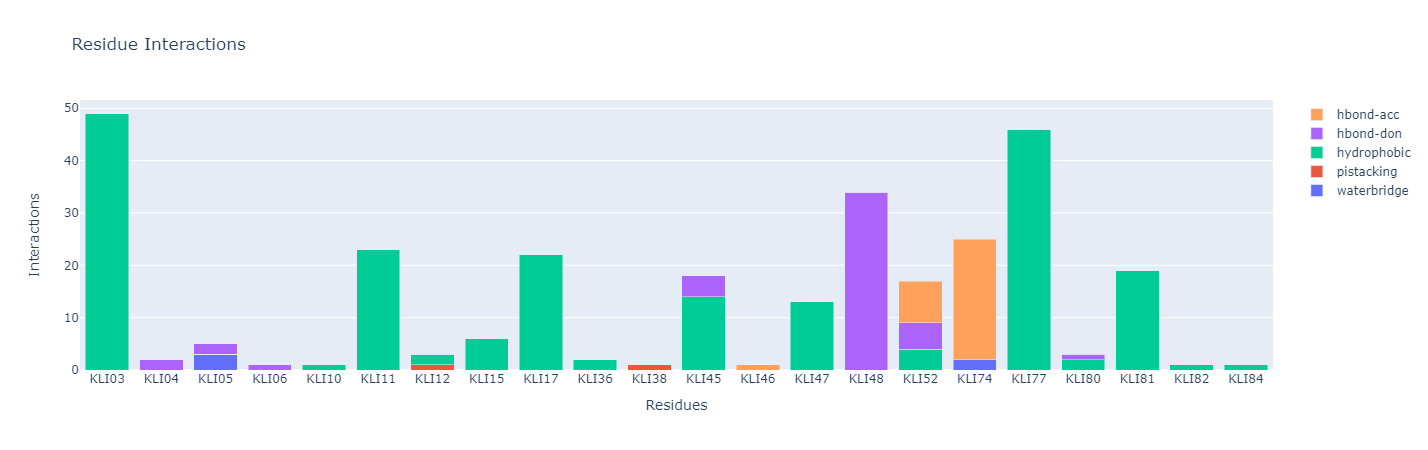

In [28]:
fingerprint_barplot(fp)

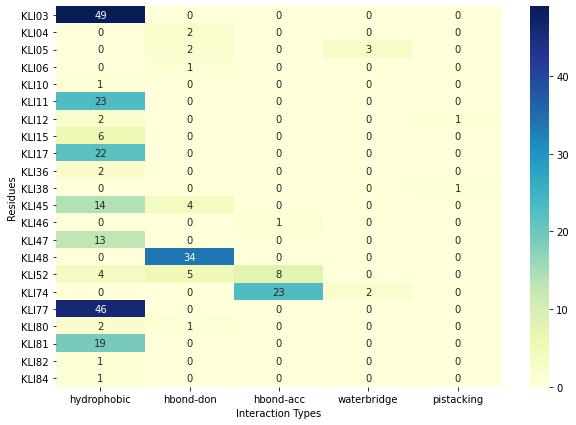

In [36]:
fingerprint_heatmap(fp, cmap="YlGnBu");

In [37]:
fingerprint_table(fp)

HTML(value='\n    <style>\n    \n    table.plipify-legend {\n        text-align: center;\n        color: #fff;…

## 03. Generate publication ready figures

TBD